# Sendit Google Deep Learning Lungren Metrics

This is the second round of sendit, and we want to look at files (or MB) processed per second, and per minute. This is the log produced after running the pipeline for N days after the start (9/5/2017), so for the date 9-08 this would mean 3 days. This log includes a couple of manual tester runs (you will see them below in the data). This dataset is different from the first in that there are very few files per compressed image package.

In [1]:
import pandas
from glob import glob
glob('*.tsv')

['sendit-process-time-2017-09-08.tsv', 'sendit-process-time-2017-09-06.tsv']

In [2]:
files = glob('*.tsv')
df = pandas.read_csv(files[0],sep="\t",index_col=0)
done = df[df.status=="DONE"]
print("Folders that are done: %s" %done.shape[0])

Folders that are done: 10079


Above we filter the frame of data collected to those that have a status of DONE. This means we can be confident about a start and finish time being present. 


## What is the size of a batch?
The first plot will show all the data, and the below will be filtered to not include outliers.

In [3]:
df.size_mb.describe()

count    10079.000000
mean        16.373695
std         10.014129
min          0.006363
25%         12.520584
50%         12.521494
75%         17.849934
max        255.815571
Name: size_mb, dtype: float64

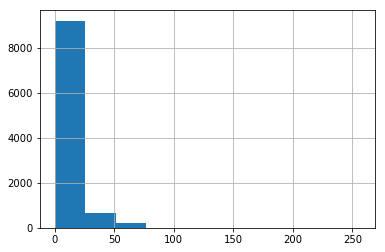

In [4]:
%matplotlib inline
df.size_mb.hist()

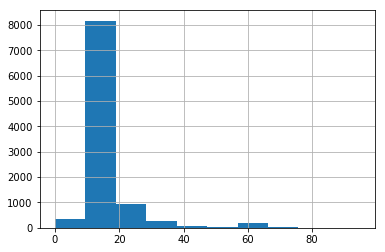

In [5]:
# And remove outliers greater than 100
%matplotlib inline
df[df.size_mb < 100].size_mb.hist()


## Plotting Distributions of MB per Time Unit
Below we will plot first MB per minute, and then MB per second. This is done with 16 cores (each core corresponding to a worker).

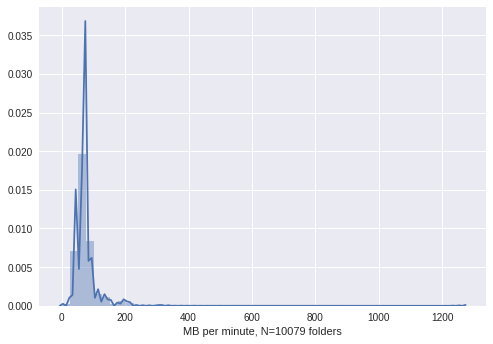

In [6]:
%matplotlib inline
import seaborn as sns
sns.set()
mb_min = done.size_mb / done.total_time_min
ax = sns.distplot(mb_min)
ax.set_xlabel("MB per minute, N=%s folders" %done.shape[0])

In [10]:
# How many MB per minute, hour, day, are we moving, on average?
timings = pandas.DataFrame(columns=['mb_min','mb_hour','mb_day','gb_day'])
timings.mb_min = mb_min
timings.mb_hour = mb_min * 60
timings.mb_day = mb_min * 60 * 24
timings.gb_day = timings.mb_day / 1000
timings.describe()

,mb_min,mb_hour,mb_day,gb_day
count,10079.000000,10079.000000,1.007900e+04,10079.000000
mean,75.567487,4534.049194,1.088172e+05,108.817181
std,35.864674,2151.880466,5.164513e+04,51.645131
min,0.068423,4.105354,9.852851e+01,0.098529
25%,61.441615,3686.496882,8.847593e+04,88.475925
50%,71.379841,4282.790459,1.027870e+05,102.786971
75%,78.699772,4721.986349,1.133277e+05,113.327672
max,1267.820241,76069.214461,1.825661e+06,1825.661147


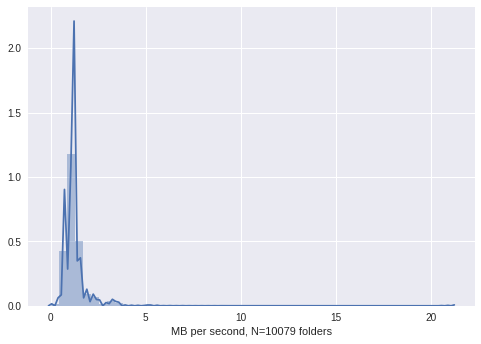

In [4]:
mb_sec = done.size_mb / done.total_time_sec
ax = sns.distplot(mb_sec)
ax.set_xlabel("MB per second, N=%s folders" %done.shape[0])

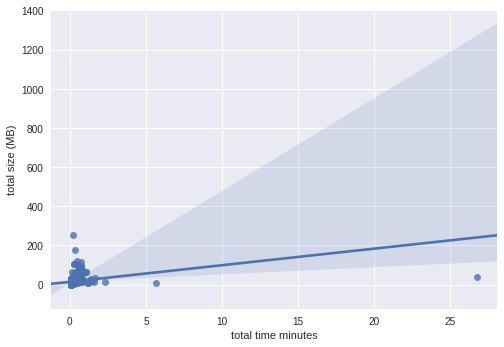

In [5]:
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x=done.total_time_min, y=done.size_mb)
ax.set_xlabel("total time minutes")
ax.set_ylabel("total size (MB)")

Ha, see the two losers on the right? Those are actually test cases that I was (manually) testing. Let's remove them.

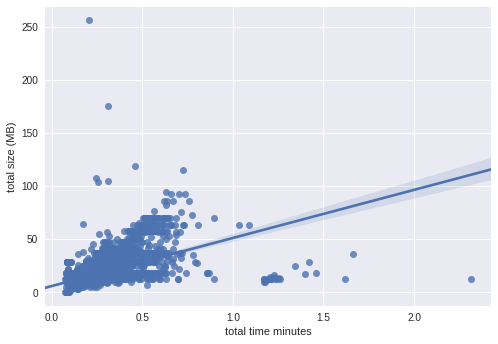

In [6]:
filtered = done[done.total_time_min<5]
ax = sns.regplot(x=filtered.total_time_min, y=filtered.size_mb)
ax.set_xlabel("total time minutes")
ax.set_ylabel("total size (MB)")

In [7]:
filtered.mean()

batch_id          5.306808e+03
size_mb           1.637213e+01
start_time        1.504766e+09
finish_time       1.504766e+09
total_time_sec    1.395025e+01
total_time_min    2.325041e-01
dtype: float64

In [8]:
filtered.std()

batch_id           2950.178347
size_mb              10.012416
start_time        66391.320586
finish_time       66391.159786
total_time_sec        7.400434
total_time_min        0.123341
dtype: float64

Again, for each batch there are anywhere between 1 and 10 images. I would say on average (just glancing at logs) it's usually 2-3, sometimes 4 and 1.